# Set up

In [15]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib notebook

# XTRUE.M

Function __x_true__ simulates the true state of nature/process x and observations z, where
\begin{align}
\ x(k) &= F(k) x(k-1) + B(k) u(k) + G(k) v(k)\\
\ z(k) &= H(k) x(k) + D(k) w(k)
\end{align}

where (known variance)
\begin{align}
\mathbf{E} \big[v(i) \mathbf{v}^\intercal (j) \big] &= \delta_ij Q(i) \\
\mathbf{E} \big[w(i) \mathbf{w}^\intercal (j) \big] &= \delta_ij R(i) \\
\end{align}


In [16]:
def x_true(F, G, H, Q, R, x0, t_steps):
    '''
    % A function to compute true state-space history
    % and true observations from a discrete-time
    % model with no input. For use with a Kalman Filter
    %
    % Inputs: F   Xsize*Xsize state transition matrix
    %         G   Xsize*Vsize state noise transition matrix
    %         H   Zsize*Xsize observation matrix
    %         Q   Vsize*Vsize process noise covariance matrix
    %         R   Zsize*Zsize observation noise covariance matrix
    %         x0  Xsize*1 initial state vector 
    %         t_steps, number of time-steps to be simulated
    %
    % Outputs: z  Zsize*t_steps Observation time history
    %          x  Xsize*t_steps true state time history
    ''' 
    # First check all matrix dimensions
    [Rows,Cols] = F.shape
    if Rows != Cols: raise Exception('F is non-square')
        
    [Xsize,nul]=x0.shape
    if Xsize != Rows: raise Exception('x0 does not match dimension of F')
        
    [Rows,Vsize]=G.shape
    if Xsize != Rows: raise Exception('G does not match dimension of F')
        
    [Rows,Cols]=Q.shape
    if Rows != Cols: raise Exception('Q must be square')
        
    if Vsize != Rows: raise Exception('Q does not match dimension of G')
        
    [Zsize,Cols]=H.shape
    if Cols != Xsize: raise Exception('H and Xsize do not match')
        
    [Rows,Cols]=R.shape
    if Rows != Cols: raise Exception('R must be square')
        
    if Rows != Zsize: raise Exception('R must match Zsize of H')
        
   # fix up output matricies
    x = np.zeros((Xsize, t_steps+1))
    z = np.zeros((Zsize, t_steps+1))
    
    # get some gaussian noise - rand('normal')
    v = math.sqrt(Q) * np.random.randn(Vsize, t_steps+1)
    w = math.sqrt(R) * np.random.randn(Zsize, t_steps+1)
    
    # initial value
    x0 = x[:,0].reshape(2,1)
    
    # now generate all the remaining states
    for i in range(t_steps):
        x[:, i+1] = np.dot(F, x[:,i]) + np.dot(G, v[:,i]) #Assuming no control inputs B and u
        
    # then all the observations
    for i in range(1, t_steps+1):
        z[:, i] = np.dot(H, x[:,i]) + w[:, i]
        
    return z, x

# run_sim.m

```javascript
# continuous time state transition matrix
A = np.array([[0, 1]
            , [0, 0]])
```

```javascript
# continuous time input model
B = np.array([[0]
            , [1]])
```

In [4]:
# observation model
H = np.array([[1, 0]])

In [5]:
# continuous time noise variance, must be square
Q = np.array([[0.01]]) 

In [6]:
# observation noise variance, must be square
R = np.array([[1]])

In [7]:
# initial conditions
x0 = np.array([[0]
            ,[0]])

In [8]:
# sample period
dt = 1.0

In [9]:
# number of time-steps to simulate
t_steps = 500

In [10]:
time = range(t_steps+1)

In [11]:
#Transform a continuous to a discrete state-space system.
F = np.array([[1, dt]
            , [0, 1]])

G = np.array([[dt**2/2]
            , [dt]])

<div class="alert alert-block alert-warning">
<b>Note from Hugh:</b> For this problem, just replace c2d with direct digital results: F=[1,dt; 0, 1], G=[dt^2/2; dt] (this is what you get if you integrate A=[0, 1; 0, 0] and B=[1, 0] over the time interval dt.).
</div>

In [12]:
# Run simulation
z, x = x_true(F, G, H, Q, R, x0, t_steps)

# rplots.m

<IPython.core.display.Javascript object>


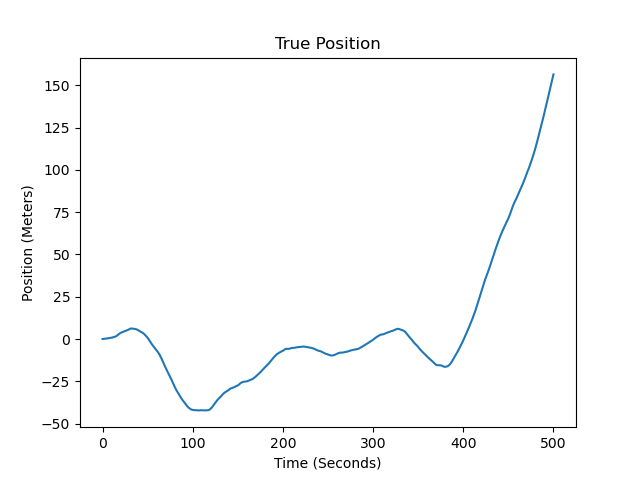

Text(0.5, 1.0, 'True Position')

In [13]:
#Figure 1
plt.figure()
plt.plot(time, x[0,:])

# Set label axis
plt.xlabel('Time (Seconds)')
plt.ylabel('Position (Meters)')
plt.title('True Position')

<IPython.core.display.Javascript object>


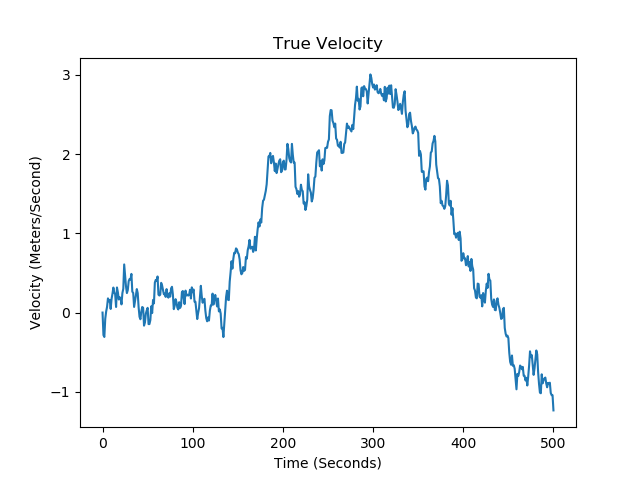

Text(0.5, 1.0, 'True Velocity')

In [13]:
#Figure 2
plt.figure()
plt.plot(time, x[1,:])

# Set label axis
plt.xlabel('Time (Seconds)')
plt.ylabel('Velocity (Meters/Second)')
plt.title('True Velocity')

<IPython.core.display.Javascript object>


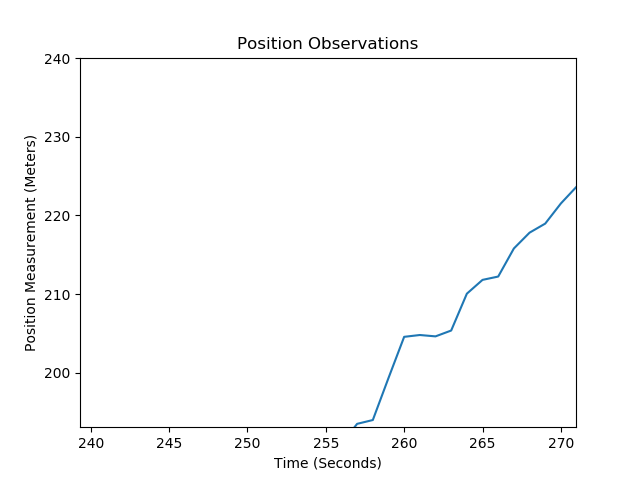

Text(0.5, 1.0, 'Position Observations')

In [14]:
#Figure 3
plt.figure()
plt.plot(time, z[0,:])

# Set label axis
plt.xlabel('Time (Seconds)')
plt.ylabel('Position Measurement (Meters)')
plt.title('Position Observations')

<IPython.core.display.Javascript object>


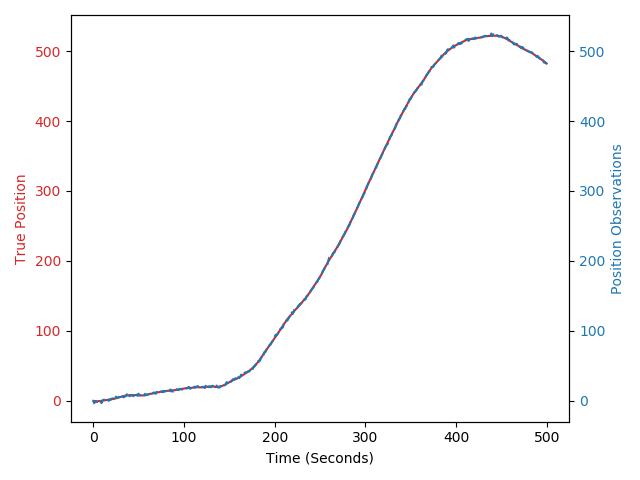

In [15]:
# Check true target track and position observations
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time (Seconds)')
ax1.set_ylabel('True Position', color=color)
ax1.plot(time, x[0,:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# instantiate a second axes that shares the same x-axis and y-axis
ax2 = ax1.twinx()  
ax1.get_shared_y_axes().join(ax1, ax2)

color = 'tab:blue'
ax2.set_ylabel('Position Observations', color=color)  
ax2.plot(time, z[0,:], color=color, linestyle = '--')
ax2.tick_params(axis='y', labelcolor=color)
    
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# run_filt.m

Run the Kalman Filter

# Covars.m

__Prediction__: A prediction ˆx(k | k − 1) of the state at time k and its covariance P(k | k − 1)
is computed according to:
    
\begin{align}
\ \hat{x}(k|k-1) &= F(k) \hat{x}(k-1|k-1) + B(k) u(k)\\
\ P(k|k-1) &= F(k) P(k-1|k-1) \mathbf{F}^\intercal (k) + G(k) Q(k) \mathbf{G}^\intercal (k)
\end{align}

__Innovation:__ the difference between the observation 𝑧(𝑘) and the predicted observation 𝐻(𝑘)𝑥̂ (𝑘|𝑘−1) is the innovation (or residual 𝑣(𝑘)). And covar S(k)
\begin{align}
\ S(k) &= R(k) + H(k) P(k|k-1) H(k) \\
\ v(k) &= z(k) - H(k) \hat{x}(k|k-1)
\end{align}

__Gain matrix:__
\begin{align}
\ W(k) = P(k|k-1) + H(k) S^{-1}(k)
\end{align}

__Update:__ state and var at time k on the basis of the predicted state and var and the new observation 𝑧(𝑘)
\begin{align}
\ \hat{x}(k|k) &= \hat{x}(k|k-1) + W(k) v(k)\\
\ P(k|k) &= P(k|k-1) - W(k) S(k) \mathbf{W}^\intercal (k)
\end{align}


In covars code:
* __Prediction__: lPpred = 𝑃(𝑘|𝑘−1)
* __Innovation__: lS = 𝑆(𝑘)
* __Gain matrix__: lW = 𝑊(𝑘)
* __Update__: lPest = 𝑃(𝑘|𝑘)

In xestim code:
* __Prediction__: xpred = 𝑥̂ (𝑘|𝑘−1)
* __Innovation__: innov = 𝑣(𝑘)
* __Gain matrix__: lW = 𝑊(𝑘)
* __Update__: xest=  𝑥̂ (𝑘|𝑘)

In [16]:
def covars(F, G, H, Q, R, P0, t_steps):
    '''
    % A function to compute gain and covariance history for a Kalman Filter
    %
    % Inputs: F   Xsize*Xsize state transition matrix
    %         G   Xsize*Vsize state noise transition matrix
    %         H   Zsize*Xsize observation matrix
    %         Q   Vsize*Vsize process noise covariance matrix
    %         R   Zsize*Zsize observation noise covariance matrix
    %         P0  Xsize*Xsize initial state covariance
    %         t_steps, number of time-steps to be simulated
    %
    % Outputs: W     t_steps*(Xsize*Zsize): Gain history
    %          Pest  t_steps*(Xsize*Xsize): Estimate Covariance history
    %          Ppred t_steps*(Xsize*Xsize): Prediction Covariance history
    %          S     t_steps*(Xsize*Xsize): Innovation Covariance history
    ''' 
    # First check all matrix dimensions
    [Xsize, Cols] = P0.shape
    if Xsize != Cols: raise Exception('P0 must be square')
    
    [Rows,Cols] = F.shape
    if Rows != Cols: raise Exception('F is non-square')
    
    if Rows != Xsize: raise Exception('F state dimension does not match Xsize')
        
    [Rows,Vsize]=G.shape
    if Xsize != Rows: raise Exception('G does not match dimension of F')
        
    [Rows,Cols]=Q.shape
    if Rows != Cols: raise Exception('Q must be square')
        
    if Vsize != Rows: raise Exception('Q does not match dimension of G')
        
    [Zsize,Cols]=H.shape
    if Cols != Xsize: raise Exception('H and Xsize do not match')
        
    [Rows,Cols]=R.shape
    if Rows != Cols: raise Exception('R must be square')
        
    if Rows != Zsize: raise Exception('R must match Zsize of H')
 
    # fix up output matricies
    W = np.zeros((t_steps, Xsize * Zsize))
    Pest = np.zeros((t_steps, Xsize * Xsize))
    Ppred = np.zeros((t_steps, Xsize * Xsize))
    S = np.zeros((t_steps, Zsize * Zsize))
    
    # initial value
    lPest = P0
    
   # ready to go !
    for i in range(1, t_steps): 
        # first the actual calculation in local variables
        lPpred = np.linalg.multi_dot([F, lPest, F.T]) + np.linalg.multi_dot([G, Q, G.T])
        lS = np.linalg.multi_dot([H, lPpred, H.T]) + R
        lW = np.linalg.multi_dot([lPpred, H.T, np.linalg.inv(lS)]) 
        lPest = lPpred - np.linalg.multi_dot([lW, lS, lW.T])
        # then record the results in columns of output states
        Pest[i, :] = lPest.reshape(1, Xsize*Xsize)
        Ppred[i, :] = lPpred.reshape(1, Xsize*Xsize)
        W[i, :] = lW.reshape(1, Xsize*Zsize)
        S[i, :]= lS.reshape(1, Zsize*Zsize)
        
    return W, Pest, Ppred, S

In [17]:
# assumes run_sim has been run at least once
Q = Q * 10
R = R * 10

#initial covariance required, P0 has to be of the same dimension as F
P0 = np.ones((2,2)) * 10 * Q 
x0 = np.array([[0]
             , [0]])

In [18]:
[W,Pest,Ppred,S] = covars(F,G,H,Q,R,P0,t_steps)

# XESTIM.m

In [19]:
def xestim(F, G, H, Q, R, x0, P0, z):
    '''
    % Your basic linear Kalman filter. Calls COVARS for gain history.
    % Inputs: F   Xsize*Xsize state transition matrix
    %         G   Xsize*Vsize state noise transition matrix
    %         H   Zsize*Xsize observation matrix
    %         Q   Vsize*Vsize process noise covariance matrix
    %         R   Zsize*Zsize observation noise covariance matrix
    %         x0  Xsize*1 initial state vector 
    %         P0  Xsize*Xsize initial state covariance matrix
    %         z   Zsize*t_steps observation sequence to be filtered
    %
    % Outputs: xest  Xsize*t_steps estimated state time history
    %          xpred Xsize*t_steps predicted state time history
    %          innov Zsize*t_steps innovation time history
    ''' 
    # First check all matrix dimensions
    [Rows,Cols] = F.shape
    if Rows != Cols: raise Exception('F is non-square')
        
    [Xsize,nul]=x0.shape
    if Xsize != Rows: raise Exception('x0 does not match dimension of F')
        
    [Rows,Vsize]=G.shape
    if Xsize != Rows: raise Exception('G does not match dimension of F')
        
    [Rows,Cols]=Q.shape
    if Rows != Cols: raise Exception('Q must be square')
        
    if Vsize != Rows: raise Exception('Q does not match dimension of G')
        
    [Zsize,Cols]=H.shape
    if Cols != Xsize: raise Exception('H and Xsize do not match')
        
    [Rows,Cols]=R.shape
    if Rows != Cols: raise Exception('R must be square')
        
    if Rows != Zsize: raise Exception('R must match Zsize of H')
        
    [Rows,Cols]=P0.shape
    if Rows != Cols: raise Exception('P0 must be Square')

    if Rows != Xsize: raise Exception('P0 must have dimensions Xsize')
    
    [Rows,t_steps]=z.shape
    if Rows != Zsize: raise Exception('Observation Sequence must have Zsize rows')
        
   # fix up output matricies
    xest = np.zeros((Xsize, t_steps))
    xpred = np.zeros((Xsize, t_steps))
    innov = np.zeros((Zsize, t_steps))
    
   # compute all the neccesary gain matricies a priori
    W = covars(F,G,H,Q,R,P0,t_steps)[0]
    
    # initial prediction and estimate (done seperately because of X0)
    lW = W[1,:].reshape(Xsize,Zsize)
    xpred[:,1, None] = np.dot(F, x0)
    innov[:,1, None] = z[:,1] - np.dot(H, xpred[:,1])
    xest[:,1] = xpred[:,1] + np.dot(lW, innov[:,1])
    
    # now generate all the remaining estimates
    for i in range(2, t_steps):
        xpred[:,i] = np.dot(F, xest[:,i-1])
        innov[:,i] = z[:,i] - np.dot(H, xpred[:,i])
        lW = W[i,:].reshape(Xsize,Zsize)
        xest[:,i] = xpred[:,i] + np.dot(lW, innov[:,i])
        
    return xest,xpred,innov

In [20]:
[xest,xpred,xinnov] = xestim(F,G,H,Q,R,x0,P0,z)

# plots.m

<IPython.core.display.Javascript object>


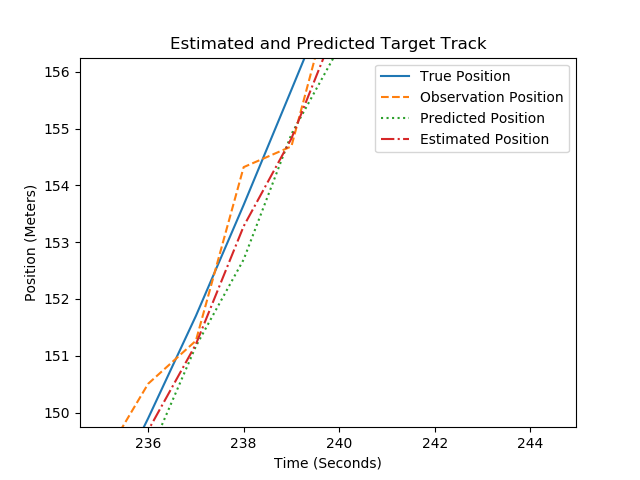

In [21]:
# Plot target position
plt.figure()
plt.plot(time, x[0,:], label = 'True Position')
plt.plot(time, z[0,:], label = 'Observation Position', linestyle = '--')
plt.plot(time, xpred[0,:], label = 'Predicted Position', linestyle = ':')
plt.plot(time, xest[0,:], label = 'Estimated Position', linestyle = '-.')

# Set label axis
plt.xlabel('Time (Seconds)')
plt.ylabel('Position (Meters)')
plt.title('Estimated and Predicted Target Track')
plt.legend()

<IPython.core.display.Javascript object>


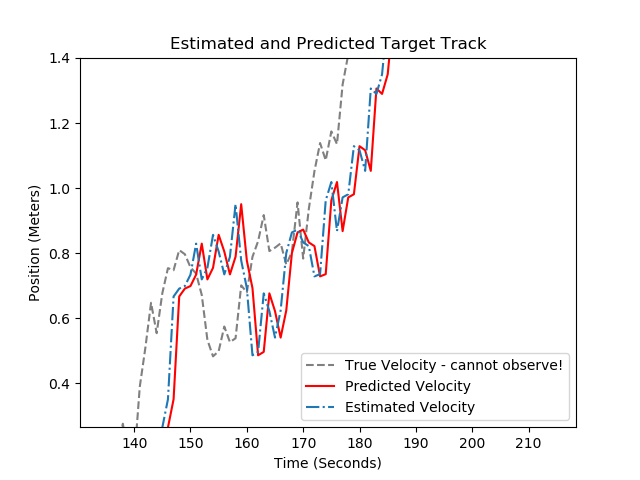

In [22]:
#Plot target velocity
plt.figure()
plt.plot(time, x[1,:], label = 'True Velocity - cannot observe!', linestyle = '--', color = 'grey')
plt.plot(time, xpred[1,:], label = 'Predicted Velocity', linestyle = '-', color = 'red')
plt.plot(time, xest[1,:], label = 'Estimated Velocity', linestyle = '-.')

# Set label axis
plt.xlabel('Time (Seconds)')
plt.ylabel('Position (Meters)')
plt.title('Estimated and Predicted Target Track')
plt.legend()

<IPython.core.display.Javascript object>


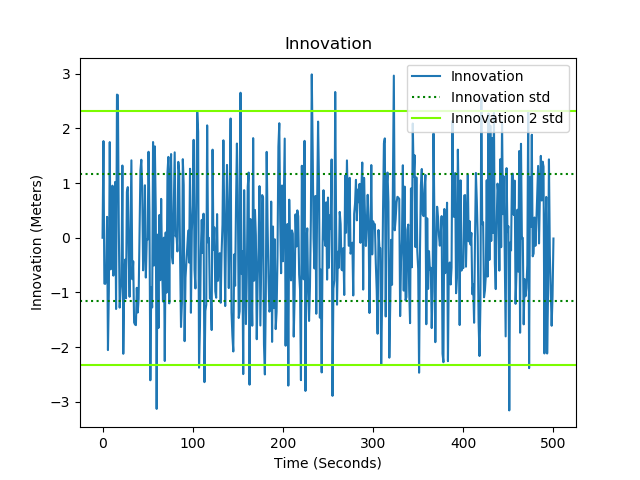

In [108]:
# Plot innovation
innov_std = xinnov[0].std()

plt.figure()
plt.plot(time, xinnov[0,:], label = 'Innovation')
plt.axhline(innov_std, color = 'green', label = 'Innovation std', linestyle = ':')
plt.axhline(-innov_std, color = 'green', linestyle = ':')
plt.axhline(2*innov_std, color = 'lawngreen', label = 'Innovation 2 std')
plt.axhline(-2*innov_std, color = 'lawngreen')

# Set label axis
plt.xlabel('Time (Seconds)')
plt.ylabel('Innovation (Meters)')
plt.title('Innovation')
plt.legend(loc = 'upper right')

<IPython.core.display.Javascript object>


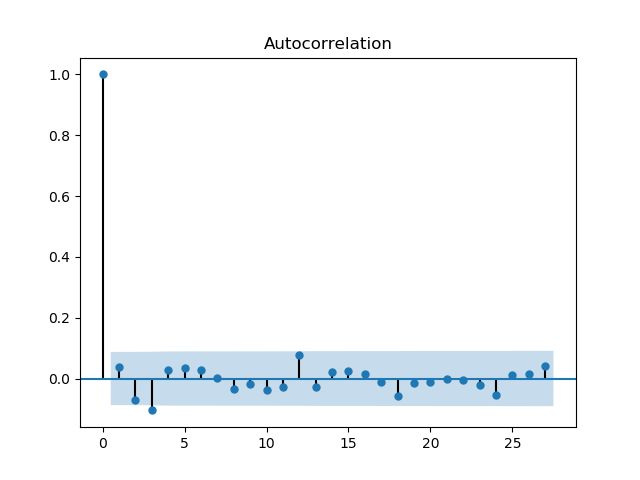

In [119]:
#Plot autocorrelation of innovation - test for whiteness
from statsmodels.graphics import tsaplots

tsaplots.plot_acf(xinnov[0,:])
plt.show()